# <center>Estimating network structure from unreliable measurements</center>

In [1]:
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

## 1. Erdös-Rényi with independent edge measurements : undirected case

### 1.1 Initialization

Number of nodes n and list of all node pairs.

In [2]:
n = 50
node_pairs = list()
for i in range(n):
    for j in range(i,n):
        if i != j:
            node_pairs.append((i,j))

Graph parameters $\gamma$.

In [3]:
w = 0.05 # prob of an edge between two nodes
print("w = {}".format(w))

w = 0.05


Generate graph.

In [4]:
G = nx.gnp_random_graph(n,w)
print("nb edges : ", G.number_of_edges())

nb edges :  69


Data parameters $\theta$.

In [5]:
a = 0.7 # true positive rate
b = 0.3 # false positive rate

Generate data.

In [6]:
n_obs = 100 # nb of times we observe each node pair
N = {e:n_obs for e in node_pairs} # nb obs for each node pair
E = {e:0 for e in node_pairs} # nb edges seen during observations for each node pair

for k in range(n_obs):
    for e in node_pairs:
        dice = random.random()
        # if true positive
        if e in G.edges and dice < a:
            E[e] += 1
        # if false positive
        elif e not in G.edges and dice < b:
            E[e] += 1

In [7]:
for e in G.edges:
    print(E[e])
print()
for e in node_pairs:
    if e not in G.edges:
        print(E[e])

67
72
71
69
64
70
70
75
66
58
66
70
67
61
67
71
80
67
70
68
75
70
75
75
70
68
65
73
74
73
67
77
70
70
62
78
63
62
71
76
69
71
70
76
69
67
72
77
74
63
66
71
76
70
66
72
66
63
66
75
79
74
71
70
64
67
67
80
68

34
32
32
28
31
28
22
28
31
24
25
39
25
26
33
27
26
23
24
27
28
26
23
38
39
29
35
24
31
29
33
25
34
31
29
31
30
34
28
36
35
23
27
27
31
36
28
34
37
25
35
31
31
27
31
25
32
34
27
30
29
33
22
30
27
38
24
36
35
32
30
28
32
34
29
31
32
41
30
28
32
24
30
24
27
29
33
31
29
30
29
29
30
25
36
33
35
21
24
30
29
29
34
24
30
26
29
25
27
25
25
28
29
36
32
33
30
32
31
32
27
26
35
30
36
24
33
32
33
27
27
27
40
26
33
30
30
31
27
26
33
22
35
35
25
34
20
31
28
31
20
31
37
30
26
30
31
24
31
31
24
31
26
24
36
28
32
40
37
31
23
29
36
34
29
31
27
27
27
26
24
22
31
29
23
37
29
23
27
24
33
35
28
32
28
35
26
34
31
26
28
35
32
30
32
37
29
35
27
29
29
26
28
33
25
29
35
36
38
25
31
34
31
32
31
33
31
37
37
23
31
28
30
35
31
28
25
31
33
33
35
33
29
34
27
23
31
30
28
29
25
32
29
35
27
30
27
28
29
27
34
32
30
21


### 1.2 Iterations

Choose number of repetitions of the whole algorithm and max iterations for each repetition.

In [13]:
repetitions = 1
max_iter = 1000

Proceed.

In [26]:
# save values at each big iter
A = list()
B = list()
W = list()


# we do multiple repetitions and then take the mean
for k in range(repetitions):
    
    try:
        
        # random initialization of the parameters
        w = random.random()
        a = random.random()
        b = random.random()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in N:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])

            # update w,a,b
            w = sum(Q.values()) / binom(n,2)
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in N:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b

            # break if no sufficient evolution
            if np.abs(min([a-old_a, b-old_b, w-old_w])) < 0.001:
                break

        # save a,b,w
        A.append(a)
        B.append(b)
        W.append(w)
    
    except:
        continue
    
    
# print values
w_final = max([(w, W.count(w)/len(W)) for w in set(W)], key=itemgetter(1))
a_final = max([(a, A.count(a)/len(A)) for a in set(A)], key=itemgetter(1))
b_final = max([(b, B.count(b)/len(B)) for b in set(B)], key=itemgetter(1))
print(" w = {}\n a = {}\n b = {}\n".format(w_final, a_final, b_final))

 w = (0.05632665520781869, 1.0)
 a = (0.6988400197749085, 1.0)
 b = (0.2988927141797083, 1.0)



Compare a posteriori edge probability with edge presence in real graph.

Text(0, 0.5, 'nb of actual edges')

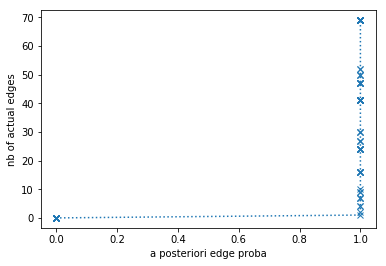

In [27]:
real_edges_count = list()
for (e,q) in sorted(Q.items(), key=itemgetter(1)):
    real_edges_count.append(0)
    for e in G.edges:
        if Q[e] <= q:
            real_edges_count[-1] += 1
plt.plot(sorted(Q.values()), real_edges_count, marker='x', ls=':')
plt.xlabel("a posteriori edge proba")
plt.ylabel("nb of actual edges")

Probability of other graphs selected at random.

In [89]:
for k in range(1000):
    G_test = nx.gnp_random_graph(n,w)
    qA = 1
    for (i,j) in N:
        if (i,j) in G_test.edges:
            qA *= Q[i,j]
        else:
            qA *= 1 - Q[i,j]
    if qA != 0:
        print(qA)

## 2. Erdös-Rényi with independent edge measurements : directed case

### 1.1 Initialization

Number of nodes n and list of all node pairs.

In [5]:
n = 20
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Graph parameters $\gamma$.

In [6]:
w = 0.05 # prob of an edge between two nodes
print("w = {}".format(w))

w = 0.05


Generate graph.

In [7]:
G = nx.gnp_random_graph(n, w, directed=True)
print("nb edges : ", G.number_of_edges())

nb edges :  18


Data parameters $\theta$.

In [8]:
a = 0.7 # true positive rate
b = 0.3 # false positive rate

Generate data.

In [9]:
n_obs = 50 # nb of times we observe each node pair
N = {e:n_obs for e in node_pairs} # nb obs for each node pair
E = {e:0 for e in node_pairs} # nb edges seen during observations for each node pair

for k in range(n_obs):
    for e in node_pairs:
        dice = random.random()
        # if true positive
        if e in G.edges and dice < a:
            E[e] += 1
        # if false positive
        elif e not in G.edges and dice < b:
            E[e] += 1

In [10]:
for e in G.edges:
    print(E[e])
print()
print("--------------------------------------------")
print()
for e in node_pairs:
    if e not in G.edges:
        print(E[e])

37
36
41
34
31
36
32
36
39
34
34
34
38
37
40
37
34
32

--------------------------------------------

11
16
13
17
13
9
13
12
13
16
14
10
10
10
13
21
16
19
22
21
12
15
19
14
22
14
14
19
12
17
17
16
15
18
15
12
15
14
12
12
17
16
14
14
15
16
16
14
16
13
20
17
25
20
18
21
12
16
15
14
18
13
19
16
13
18
18
15
16
11
7
15
18
17
18
10
17
15
13
19
16
15
17
14
14
13
18
14
17
19
11
9
19
14
12
15
12
18
13
20
14
13
15
17
14
19
13
15
19
14
15
15
10
18
16
18
17
17
14
18
17
14
19
12
18
12
6
15
13
19
18
21
20
12
8
17
12
13
14
18
9
9
12
16
13
13
9
14
19
18
13
15
13
17
17
13
15
24
12
12
13
15
16
15
8
17
14
16
15
18
16
18
17
17
12
9
9
18
15
17
10
14
21
18
16
19
12
20
19
14
16
15
13
12
14
17
26
13
13
15
18
17
9
16
14
11
12
19
15
17
15
16
17
18
12
16
18
13
21
23
11
10
23
21
13
13
16
16
15
14
20
12
19
14
12
12
16
16
12
14
13
14
14
14
16
19
23
13
25
15
14
8
13
11
19
21
19
16
12
11
9
11
12
15
14
13
14
15
22
14
11
20
18
16
14
12
11
19
13
12
13
14
20
19
14
16
13
20
18
18
12
12
15
16
14
12
17
9
19
11
19
17
11
14
12

### 1.2 Iterations

Choose max iterations.

In [11]:
max_iter = 100

Proceed.

In [12]:

# random initialization of the parameters
w = random.random()
a = random.random()
b = random.random()

# iter
for l in range(max_iter):

    old_w, old_a, old_b = w, a, b

    # compute Qij
    Q = dict()
    for (i,j) in N:
        Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
        Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])

    # update w,a,b
    w = sum(Q.values()) / (n*(n-1))
    numerator_a, numerator_b = 0, 0
    denominator_a, denominator_b = 0, 0
    for (i,j) in N:
        numerator_a += Q[i,j] * E[i,j]
        numerator_b += (1-Q[i,j]) * E[i,j]
        denominator_a += Q[i,j] * N[i,j]
        denominator_b += (1-Q[i,j]) * N[i,j]
    a = numerator_a / denominator_a
    b = numerator_b / denominator_b

    # break if no sufficient evolution
    if np.abs(min([a-old_a, b-old_b, w-old_w])) < 0.001:
        break

# print result
print(" w = {}\n a = {}\n b = {}\n".format(w, a, b))

 w = 0.04787682021357658
 a = 0.7111904890083998
 b = 0.30204289305509435



Probability of the real graph.

In [13]:
qA = 1
for (i,j) in N:
    if (i,j) in G.edges:
        qA *= Q[i,j]
    else:
        qA *= 1 - Q[i,j]
print(qA)

0.8132002649041087


Probability of other graphs selected at random.

In [14]:
for k in range(100):
    G_test = nx.gnp_random_graph(n, w, directed=True)
    qA = 1
    for (i,j) in N:
        if (i,j) in G_test.edges:
            qA *= Q[i,j]
        else:
            qA *= 1 - Q[i,j]
    if qA != 0:
        print(qA)

8.076012262882793e-227
5.236291648480574e-263
5.97728950105169e-226
1.705670817474842e-249
6.584408371631693e-229
9.223388558580706e-227
3.3514386855899993e-278
6.047637341628052e-292
1.5305655488234576e-258
6.1211023e-317
4.4738357915697135e-254
7.699899034872014e-242
1.423401027565846e-305
1.45748e-318
1.0274751378274406e-258
5.361651265466131e-276
4.807062421164956e-289
5.109443209255372e-254
3.154277726463378e-272
2.223923398965485e-290
1.8765911912961e-297
3.6457491315276285e-219
3.642598143901753e-223
1.105373451592153e-248
1.0034497667527208e-245
2.8634360541162268e-269
1.7263907905561049e-274
1.8122852908106998e-255
3.232586711109272e-281
2.0930927714024647e-284
7.163460000409805e-248
6.191699800896553e-227
2.570135927297599e-159
1.6053283344730708e-243
1.2324388008152681e-276
2.8609549727189466e-273
1.9222325558436766e-269
2.3345720365761547e-271
2.4783526878472482e-281
7.790520122139732e-308
3.154277746198577e-272
1.923899563285213e-265
4.4206560660902565e-307
2.8993046385686